<a href="https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/sign_detector_augmentated_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/sign_detector.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

In [1]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip
    !rm rtsd-dataset.zip
    !cp -r rtsd-frames/rtsd-frames/ .
    !rm -r rtsd-frames/rtsd-frames/
    !pip install fiftyone
if colab == True:
    dataset_path = '.'
    checkpoints_path = '../content/drive/MyDrive/TSR/checkpoints'
else:
    dataset_path = 'data'
    checkpoints_path = 'checkpoints'

import os
import json
import numpy as np 
import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
#import matplotlib.patches as patches
#%matplotlib inline

#from pycocotools.coco import COCO
#import fiftyone as fo
import time
import torch
import torch.nn as nn
#import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection import FasterRCNN
from torchvision.models import resnet152
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn import metrics
from torchvision import models
#import cv2
#PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

## Обучение модели

### Загрузчик данных

In [3]:
class RTSD_dataset_classifier(Dataset):
    def __init__(self, dataset_path, background_anno_file, dataset_anno_file, transforms, background_size = None):
        
        self.dataset_path = dataset_path
        self.background_anno_file = background_anno_file
        self.dataset_anno_file = dataset_anno_file
        self.transforms = transforms
        self.transforms_lib = None
        try:
            self.transforms.additional_targets == {}
            self.transforms_lib = 'albumentations'
        except:
            self.transforms_lib = 'torchvision'
        
        with open(os.path.join(dataset_path, background_anno_file), 'r') as read_file:
            self.background_anno = json.load(read_file)
        read_file.close()

        #self.df_backgrnd_anno = pd.DataFrame(self.background_anno.get('annotations'))[['image_id','bbox','category_id']]
        #self.df_backgrnd_images = pd.DataFrame(self.background_anno.get('images'))[['id','file_name']]
        #self.df_backgrnd = self.df_backgrnd_anno.merge(self.df_backgrnd_images, left_on='image_id', right_on='id',)[['file_name','bbox','category_id']]
        df_backgrnd_anno = pd.DataFrame(self.background_anno.get('annotations'))[['image_id','bbox','category_id']]
        df_backgrnd_images = pd.DataFrame(self.background_anno.get('images'))[['id','file_name']]
        df_backgrnd = df_backgrnd_anno.merge(df_backgrnd_images, left_on='image_id', right_on='id',)[['file_name','bbox','category_id']]
        if background_size is not None:
            df_backgrnd = df_backgrnd.groupby('category_id', group_keys= False).apply(lambda x: x.sample(2, replace=True))

        with open(os.path.join(dataset_path, dataset_anno_file), 'r') as read_file:
            self.anno = json.load(read_file)
        read_file.close()

        #self.df_anno = pd.DataFrame(self.anno.get('annotations'))[['image_id','bbox','category_id']]
        #self.df_images = pd.DataFrame(self.anno.get('images'))[['id','file_name']]
        #self.df_dataset = self.df_anno.merge(self.df_images, left_on='image_id', right_on='id',)[['file_name','bbox','category_id']]

        df_anno = pd.DataFrame(self.anno.get('annotations'))[['image_id','bbox','category_id']]
        df_images = pd.DataFrame(self.anno.get('images'))[['id','file_name']]
        self.df_dataset = df_anno.merge(df_images, left_on='image_id', right_on='id',)[['file_name','bbox','category_id']]
        
        self.df_dataset = pd.concat((df_backgrnd, self.df_dataset), axis=0)
        self.df_dataset.reset_index(inplace=True)
        del self.df_dataset['index']    
        #self.labels = torch.eye(156)[self.df_dataset['category_id']]'''

    def __len__(self):
        return self.df_dataset.shape[0]

    def __getitem__(self, index):
        img_name = self.df_dataset.loc[index,'file_name']
        bbox = self.df_dataset.loc[index,'bbox']
        bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
        img = Image.open(os.path.join(self.dataset_path, img_name))
        img = img.crop(bbox)
        
        if self.transforms_lib == 'torchvision':
            img = self.transforms(img)
        elif self.transforms_lib == 'albumentations':
            img = np.array(img).astype(np.float32)/255.
            img = self.transforms(image=img)['image']
            img = img.float()
        else:
            print('Ошибка выбора библиотеки аугментации')

        label = torch.tensor(self.df_dataset.loc[index,'category_id'])
    
        
        #from PIL import ImageOps
        #old_img = Image.open(image_path)
        # создание нового изображения с белым фоном
        #new_image = ImageOps.expand(old_img, border=25, fill=(255,255,255))

        return {'images':img, 'labels':label}



In [20]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(augmentation_lib = 'torchvision', train=False):
    if augmentation_lib =='torchvision':
        if train == True:
            return transforms.Compose([transforms.Resize((224,224)),
                                       #transforms.RandomPerspective(distortion_scale=0.4,p=0.7),
                                       #transforms.ColorJitter(brightness=(0.4), contrast=(0.3), saturation=(0.3)),
                                       #transforms.GaussianBlur(11, sigma=(0.1, 2.0)),
                                       #transforms.RandomAdjustSharpness(5),
                                       #transforms.RandomRotation(10),
                                       #transforms.RandomResizedCrop((224,224), scale=(0.85, 1)), # Случайная обрезка изображения в диапахоне 85 - 100% и resize в исходный размер
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],      # 1 496
                                                            [0.229, 0.224, 0.225]),
                                       #transforms.RandomErasing(p = 0.4, scale = (0.003, 0.1)),
                                       #transforms.RandomErasing(p = 0.6, scale = (0.003, 0.05)),
                                       #transforms.RandomErasing(p = 0.6, scale = (0.003, 0.05)),
                                       #transforms.RandomErasing(p = 0.6, scale = (0.003, 0.02)),
                                       #transforms.RandomErasing(p = 0.6, scale = (0.003, 0.02)),
                                       #transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                       #transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                       #transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                       #transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                       #transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                       ])
        else:
            return transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],      # 1 496
                                                         [0.229, 0.224, 0.225])
                                    ])   
    
    elif augmentation_lib =='albumentations':
        if train==True:
            return A.Compose([A.augmentations.geometric.resize.Resize (224, 224, interpolation=1, always_apply=False, p=1),
                              A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
                              A.RandomFog(fog_coef_lower=0.2, fog_coef_upper=0.3, alpha_coef=0.1, p=0.05), #Туман
                              A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=5, p=0.05),
                              A.Rotate(limit=10, p=0.5),
                              ToTensorV2(p=1.0)
                              ])
            
        else:
            return A.Compose([A.augmentations.geometric.resize.Resize (224, 224, interpolation=1, always_apply=False, p=1),
                              ToTensorV2(p=1.0)
                            ])

In [145]:
test_tvs = RTSD_dataset_classifier(dataset_path,
                               background_anno_file = 'train_anno_reduced_background.json',
                               dataset_anno_file = 'train_anno_reduced.json',
                               transforms = get_transform(augmentation_lib = 'torchvision', train=True)
                               )

1

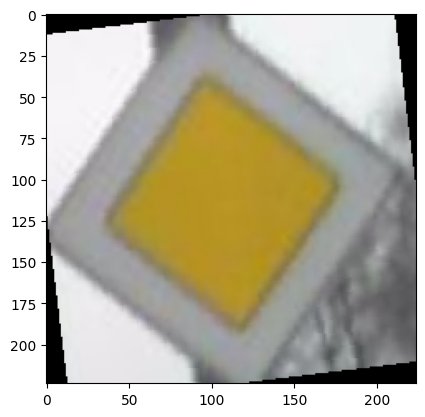

In [148]:
def plot_sign(dataset, index):
    item = dataset.__getitem__(index)
    img = item['images']
    target = item['labels']
    #img, target = test.__getitem__(index)
    img = img.permute(1, 2, 0).detach().numpy()
    img = img*255
    img = img.astype(np.uint8)
    fig, a = plt.subplots(1,1)
    #fig.set_size_inches(10,10)
    display(int(target.cpu().detach().numpy()))
    a.imshow(img)
    return None
plot_sign(test_tvs, 904)

In [6]:
test_alb = RTSD_dataset_classifier(dataset_path,
                               background_anno_file = 'train_anno_reduced_background.json',
                               dataset_anno_file = 'train_anno_reduced.json',
                               transforms = get_transform(augmentation_lib = 'albumentations', train=True)
                               )

1

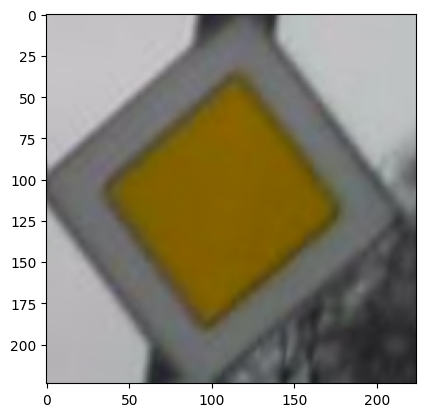

In [7]:
def plot_sign(dataset, index):
    item = dataset.__getitem__(index)
    img = item['images']
    target = item['labels']
    #img, target = test.__getitem__(index)
    img = img.permute(1, 2, 0).detach().numpy()
    img = img*255
    img = img.astype(np.uint8)
    fig, a = plt.subplots(1,1)
    #fig.set_size_inches(10,10)
    display(int(target.cpu().detach().numpy()))
    a.imshow(img)
    return None
plot_sign(test_alb, 904)

### Гиперпараметры

In [21]:
device_id = 0
if torch.cuda.is_available() == True:
    device = f'cuda:{device_id}'
elif torch.backends.mps.is_available() == True:
    device = 'mps'
else:
    device = 'cpu'

model_name = 'resnet152_test_with_bg_v100_tvs_normalize_adam_001'

last_epoch = None
n_epochs = 10
batch_size = 32
num_classes = 156

device

'cuda:0'

### Инициализация модели, задание оптимизатора и функции потерь

In [22]:
def create_model(num_classes):
    model = resnet152(weights='ResNet152_Weights.IMAGENET1K_V2')
    for param in model.parameters():
        param.requires_grad = False
    
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    #model.fc = nn.Sequential(nn.Linear(2048, 1024), nn.Linear(1024, num_classes))
    #model.fc = nn.Sequential(nn.Linear(2048, num_classes))
    for param in model.fc.parameters():
        param.requires_grad = True

    #torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1')
    #in_features = model.roi_heads.box_predictor.cls_score.in_features
    #model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{last_epoch}.pth'), map_location=device)

In [ ]:
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'losses_train', 'losses_val'])

In [23]:
model = create_model(num_classes).to(device)

loss_function = nn.CrossEntropyLoss()

# parameters
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.003, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)


#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)


# Загрузка весов модели, состояния оптимизатора и шедулера
if last_epoch is not None:
    checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{last_epoch}.pth'), map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])

train_dataset = RTSD_dataset_classifier(dataset_path,
                                        background_anno_file = 'train_anno_reduced_background.json',
                                        dataset_anno_file = 'train_anno.json',
                                        transforms = get_transform(augmentation_lib = 'torchvision', train=True)
                                        )

val_dataset = RTSD_dataset_classifier(dataset_path,
                                      background_anno_file = 'val_anno_background.json',
                                      dataset_anno_file = 'val_anno.json',
                                      transforms = get_transform(augmentation_lib = 'torchvision', train=False),
                                      background_size=100
                                      )

train_data_loader = DataLoader(
    train_dataset,
    #sampler=SubsetRandomSampler(),
    batch_size=batch_size,
    shuffle=True,
    #num_workers=4,
    #collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    #sampler=SubsetRandomSampler(),
    batch_size=batch_size,
    shuffle=False,
    #num_workers=4,
    #collate_fn=collate_fn
)

### Трейн луп

In [24]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)

    training_loss=0
    # для текущего accuracy
    correct = 0.0
    total = 0.0
    # для вывода метрик
    y_true = []
    y_pred = []

    model.train()
    running_loss = 0        # training_loss
    
    for batch_idx, data in enumerate(train_dataloader):
        
        
        
        optimizer.zero_grad()
        #images, targets = data[0], data[1]
        #images = images.to(device)
        #targets = targets.to(device)
        images = data['images'].to(device)
        targets = data['labels'].to(device)
        output = model(images)
        loss = loss_function(output, targets)
        loss.backward()
        optimizer.step()
       
        running_loss = running_loss + ((1/(batch_idx+1))*(loss.data-running_loss))
        if batch_idx%20 == 0:
            print(f"Batch Id {batch_idx} is having training loss of {running_loss}")
            print(loss.item())

        pred = output.data.max(1,keepdim=True)[1]

        # для текущего accuracy
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
        print(f"Epoch #{epoch}. Accuracy on batch {batch_idx}/{len_dataloader}  on Training is {(100*correct/total)}")
        
        # для вывода метрик
        y_true.extend([int(item) for item in targets])
        y_pred.extend([int(item) for item in pred])

        #images = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #loss_dict = model(images, targets)
        #loss = sum(loss for loss in loss_dict.values())
        #running_loss += loss.item()
        #loss.backward()
        #optimizer.step()
        #if batch_idx % 50 == 0:
        #    print(f"\tЭпоха {epoch}. Итерация {batch_idx}/{len_dataloader}. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    train_accuracy = metrics.accuracy_score(y_true, y_pred)
    train_f1_micro = metrics.f1_score(y_true, y_pred, average="micro")
    train_f1_macro =  metrics.f1_score(y_true, y_pred, average="macro")
    train_f1_weighted = metrics.f1_score(y_true, y_pred, average="weighted")
    return train_loss, train_accuracy, train_f1_micro, train_f1_macro, train_f1_weighted

In [25]:
def val (val_dataloader, epoch):
    len_dataloader = len(val_dataloader)

    validation_loss=0
    # для текущего accuracy
    correct = 0.0
    total = 0.0
    # для вывода метрик
    y_true = []
    y_pred = []

    model.eval()

    for batch_idx, data in enumerate(val_dataloader):
        
        
        optimizer.zero_grad()
        #images, targets = data[0], data[1]
        #images = images.to(device)
        #targets = targets.to(device)
        images = data['images'].to(device)
        targets = data['labels'].to(device)
        #with torch.no_grad():
            
        output = model(images)
        loss = loss_function(output, targets)
        
        validation_loss = validation_loss + ((1/(batch_idx+1))*(loss.data-validation_loss))
        #if batch_idx%20 == 0:
        print(f"Epoch #{epoch}. Batch Id {batch_idx}/{len_dataloader}  is having validation loss of {validation_loss}")
        print(loss.item())
        pred = output.data.max(1,keepdim=True)[1]

        # для текущего accuracy
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
        print(f"Epoch #{epoch}. Batch Id {batch_idx}/{len_dataloader}  is having validation accuracy of {(100*correct/total)}")

        # для вывода метрик
        y_true.extend([int(item) for item in targets])
        y_pred.extend([int(item) for item in pred])
        #images = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #loss_dict = model(images, targets)
        #loss = sum(loss for loss in loss_dict.values())
        #running_loss += loss.item()
        #loss.backward()
        #optimizer.step()
        #if batch_idx % 50 == 0:
        #    print(f"\tЭпоха {epoch}. Итерация {batch_idx}/{len_dataloader}. Loss: {loss}")
    val_loss = validation_loss/len(val_dataloader.dataset)
    val_accuracy = metrics.accuracy_score(y_true, y_pred)
    val_f1_micro = metrics.f1_score(y_true, y_pred, average="micro")
    val_f1_macro =  metrics.f1_score(y_true, y_pred, average="macro")
    val_f1_weighted = metrics.f1_score(y_true, y_pred, average="weighted")


    return val_loss, val_accuracy, val_f1_micro, val_f1_macro, val_f1_weighted

In [26]:
# Загрузка словарей с лоссами
if last_epoch is not None:
    train_losses = checkpoint['losses_train']
    val_losses = checkpoint['losses_val']
    train_accuracies = checkpoint['accuracies_train']
    val_accuracies = checkpoint['accuracies_val']
    train_f1_micros = checkpoint['train_f1_micro']
    val_f1_micros = checkpoint['val_f1_micro']
    train_f1_macros = checkpoint['train_f1_macro']
    val_f1_macros = checkpoint['val_f1_macro']
    train_f1_weighteds = checkpoint['train_f1_weighted']
    val_f1_weighteds = checkpoint['val_f1_weighted']
else:
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_f1_micros = []
    val_f1_micros = []
    train_f1_macros = []
    val_f1_macros = []
    train_f1_weighteds = []
    val_f1_weighteds = []

if last_epoch is None:
    start_epoch = 0
else:
    start_epoch = last_epoch +1

try:
    for epoch in range(start_epoch, n_epochs):
        start = time.time()
        train_loss, train_accuracy, train_f1_micro, train_f1_macro, train_f1_weighted = train(train_data_loader, epoch)
        val_loss, val_accuracy, val_f1_micro, val_f1_macro, val_f1_weighted = val(val_data_loader, epoch)
        #lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_f1_micros.append(train_f1_micro)
        val_f1_micros.append(val_f1_micro)
        train_f1_macros.append(train_f1_macro)
        val_f1_macros.append(val_f1_macro)
        train_f1_weighteds.append(train_f1_weighted)
        val_f1_weighteds.append(val_f1_weighted)
        

        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    #'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                    'losses_train': train_losses,
                    'losses_val': val_losses,
                    'accuracies_train': train_accuracies,
                    'accuracies_val': val_accuracies,
                    'f1_micros_train': train_f1_micros,
                    'f1_micros_val': val_f1_micros,
                    'f1_macros_train': train_f1_macros,
                    'f1_macros_val': val_f1_macros,
                    'f1_weighteds_train': train_f1_weighteds,
                    'f1_weighteds_val': val_f1_weighteds,
                    }, os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{epoch}.pth'))
    
        torch.save(model, os.path.join(checkpoints_path, f'model_classifier_{model_name}_{epoch}.pth'))
    
except KeyboardInterrupt:
    print('Прервано пользователем')

Batch Id 0 is having training loss of 5.047523498535156
5.047523498535156
Epoch #0. Accuracy on batch 0/3013  on Training is 3.125
Epoch #0. Accuracy on batch 1/3013  on Training is 3.125
Epoch #0. Accuracy on batch 2/3013  on Training is 4.166666666666667
Epoch #0. Accuracy on batch 3/3013  on Training is 5.46875
Epoch #0. Accuracy on batch 4/3013  on Training is 7.5
Epoch #0. Accuracy on batch 5/3013  on Training is 10.9375
Epoch #0. Accuracy on batch 6/3013  on Training is 11.607142857142858
Epoch #0. Accuracy on batch 7/3013  on Training is 14.0625
Epoch #0. Accuracy on batch 8/3013  on Training is 15.972222222222221
Epoch #0. Accuracy on batch 9/3013  on Training is 16.5625
Epoch #0. Accuracy on batch 10/3013  on Training is 16.193181818181817
Epoch #0. Accuracy on batch 11/3013  on Training is 17.1875
Epoch #0. Accuracy on batch 12/3013  on Training is 18.028846153846153
Epoch #0. Accuracy on batch 13/3013  on Training is 17.857142857142858
Epoch #0. Accuracy on batch 14/3013  on

In [55]:
item = 5509
model.eval()
pred = model(val_dataset.__getitem__(item)['images'].unsqueeze(0).to(device)).data.max(1,keepdim=True)[1], 
int(pred[0][0][0]), int(val_dataset.__getitem__(item)['labels'])

(41, 116)

In [ ]:
val_f1_micros

[0.8046910239061795,
 0.8287099684258006,
 0.8424672981506539,
 0.8456247180875056,
 0.8575778078484438,
 0.8581416328371674,
 0.860509697789806,
 0.8623139377537212,
 0.8636671177266576,
 0.8653585926928282]

In [16]:
model_name

'resnet152_test_with_bg_v100_tvs_erasing_1_04_0003_01_2_06_0003_005_2_06_0003_002_5_06_0001_001_adam_001'

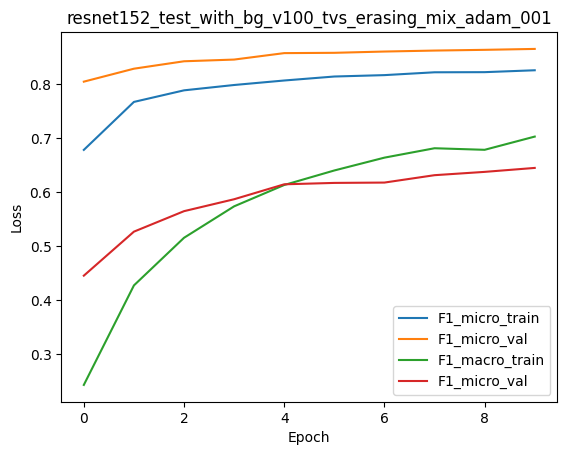

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_f1_micros, label='F1_micro_train')
ax.plot(val_f1_micros, label='F1_micro_val')
ax.plot(train_f1_macros, label='F1_macro_train')
ax.plot(val_f1_macros, label='F1_micro_val')
ax.set_title(model_name)
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()
plt.show()